In [352]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## SIR model with mutation and vaccination (SIRS model)

The SIRS model can be expressed as a system of ODEs:

$$
\frac{dS}{dt} = - \frac{a}{N} I S - c S + e R
$$

$$
\frac{dI}{dt} = \frac{a}{N} I S - b I
$$

$$
\frac{dR}{dt} = b I + c S - e R
$$

The parameters are defined as follows:
- $N$: total population
- $a$: infection rate
- $b$: recovery rate
- $c$: vaccination rate
- $e$: mutation rate or waning immunity rate

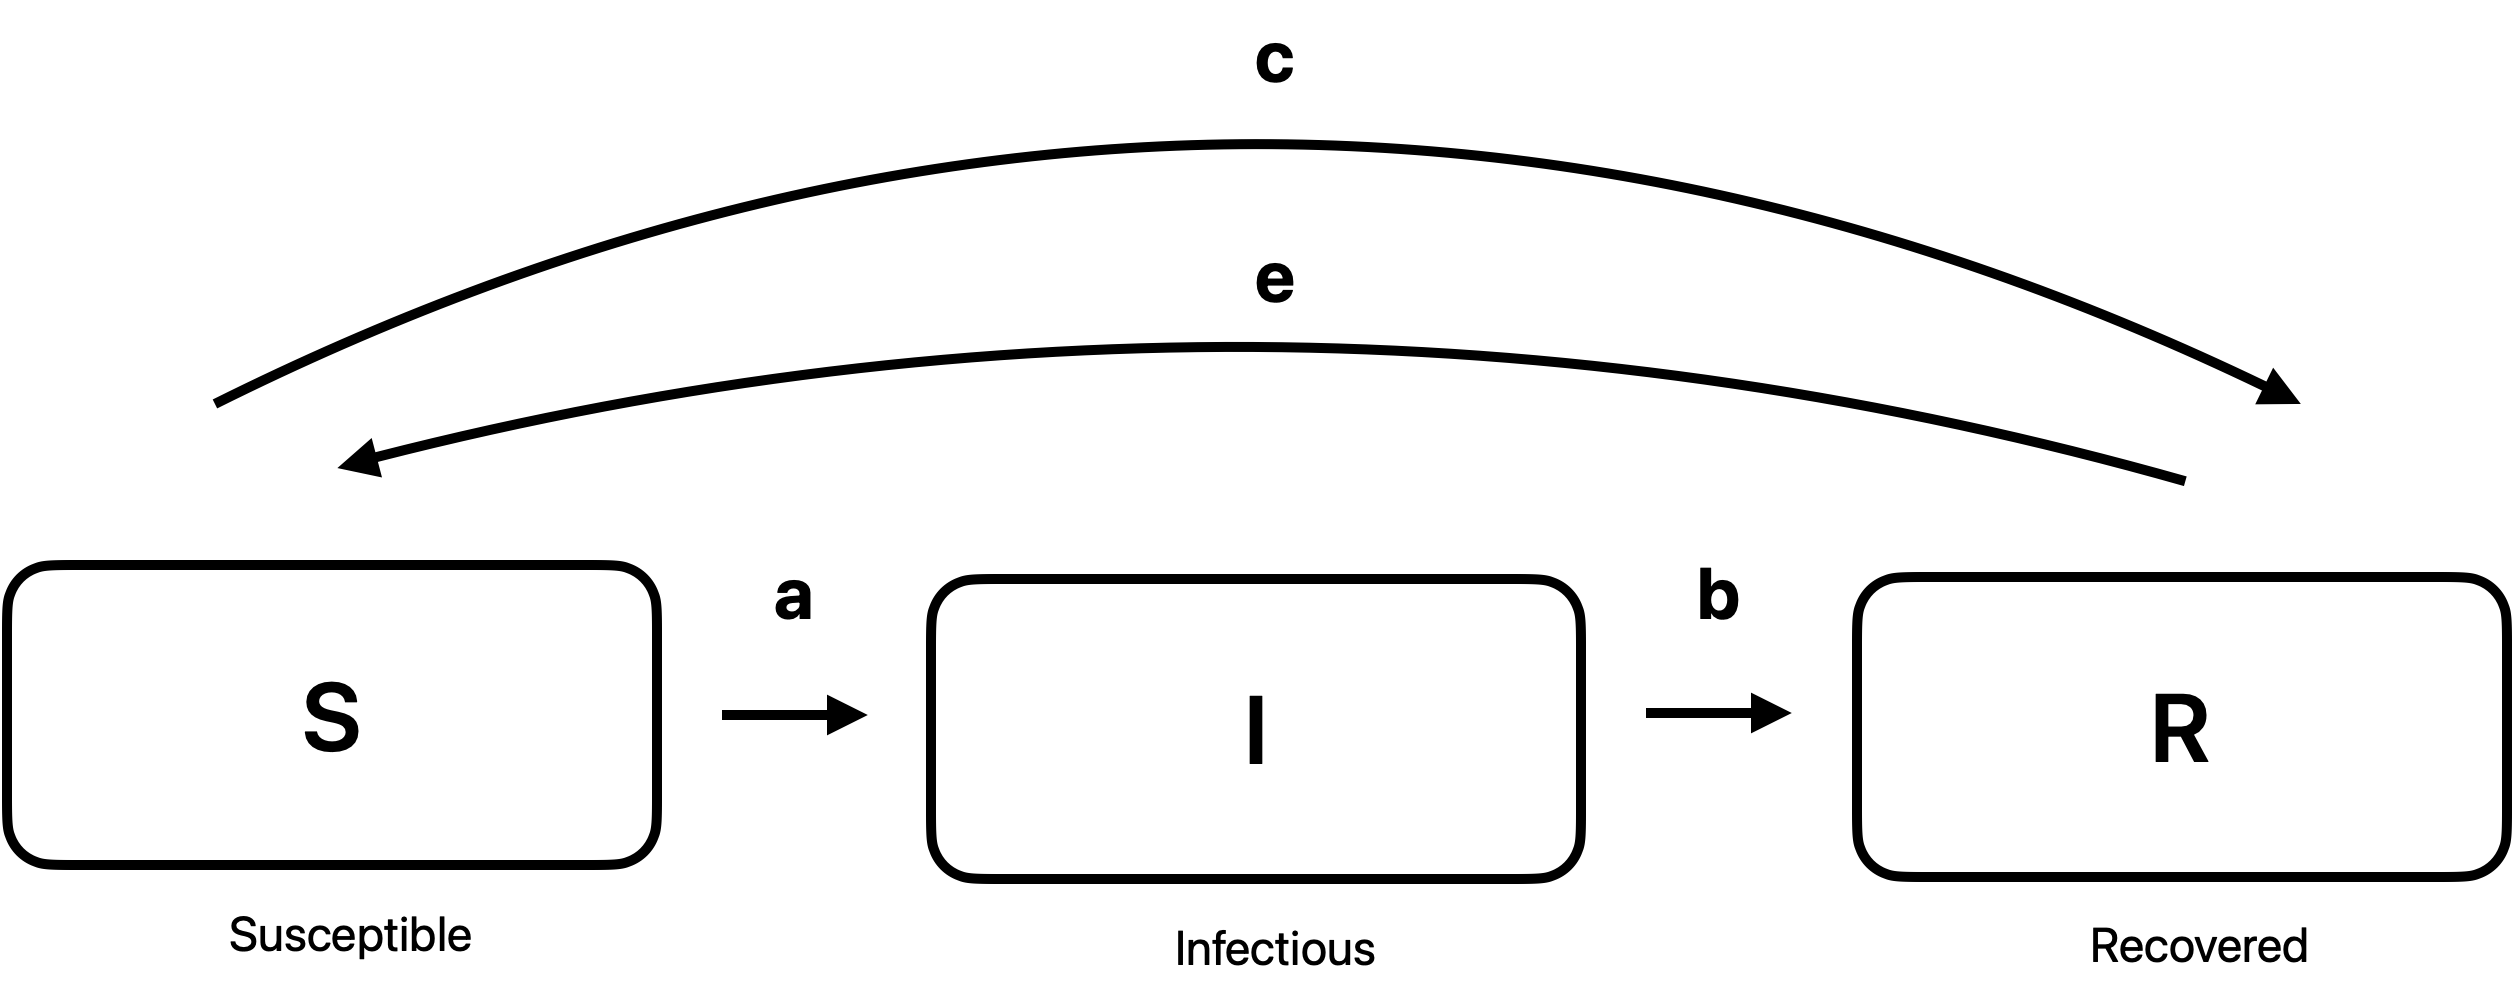

In [353]:
from IPython.display import Image

Image("./SIRS_DAG.png", width=500, height=500)

In [354]:
def sir(t, X, a, b, c, e, N):

    s = X[0]
    i = X[1]
    r = X[2]
    cumulative = X[3]

    ds = -a * s * i / N - c * s + e * r
    di = a * i * s / N - b * i
    dr = b * i + c * s - e * r
    dcumulative = b * i

    return [ds, di, dr, dcumulative]


# Set parameters
tspan = [0.0, 100]
t_eval = np.arange(0, 100, 0.1)
a = 3 * np.log(2)
b = np.log(2)
c = 0.1
e = 0.08
N = 1000

# S, I, R
X0 = [990, 10, 0, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(sir, tspan, X0, args=(a, b, c, e, N), method="Radau", t_eval=t_eval)
# Unpack solution
T, X = sol.t, sol.y

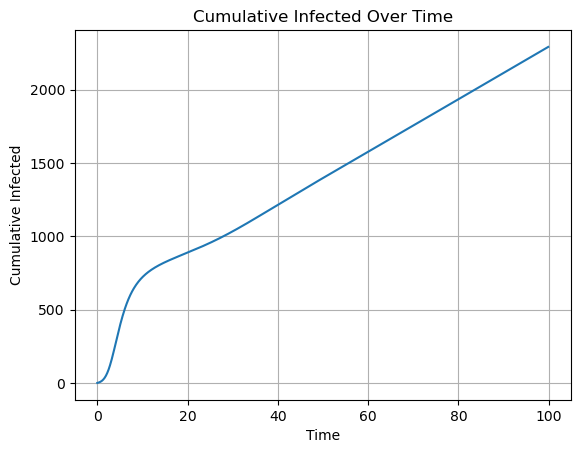

In [355]:
plt.plot(T, X[3], label="Cumulative Infected")
plt.xlabel("Time")
plt.ylabel("Cumulative Infected")
plt.title("Cumulative Infected Over Time")
plt.grid()

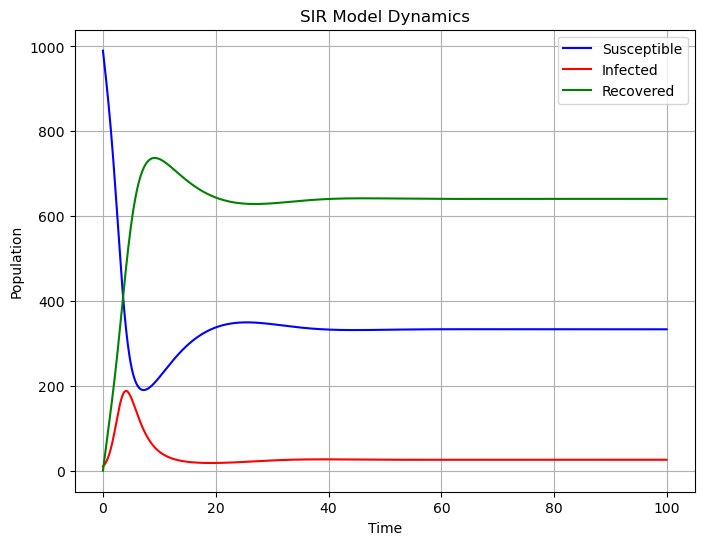

In [356]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics")
ax.legend()
ax.grid()
plt.show()

In [357]:
Rinf = X[2][-1]  # Total recovered at the end of the simulation
Rinf

640.794767872668

- endemic equilibrium

To find when the population of Susceptible when the number of Infected will decrease, we can set $\frac{dI}{dt} = 0$. This gives us:

$$
\frac{a}{N} I S - b I = 0.
$$

$$
\frac{a}{N} S = b. \rightarrow S = \frac{bN}{a}.
$$

From the above, we can say that the proportion of Susceptible individuals at which the number of Infected individuals will start to decrease is when

$$
\frac{S}{N} < \frac{b}{a}.
$$

When the proportion of Susceptible individuals is less than the inverse of the $R_0$ value, the number of Infected individuals will start to decrease.


**Remark**:

To confirm critical point found above is a maximum, we'll take the second derivative:

$$
\frac{d^2I}{dt^2} = I' (\frac{a}{N} S - b) + I \frac{a}{N} S'.
$$

Evaluate it at the critical point:

$$
\frac{d^2I}{dt^2} = I \frac{a}{N} S'
$$

Plug in $S' = - \frac{a}{N} IS$:

$$
\frac{d^2I}{dt^2} = - \frac{a^2}{N}I^2S
$$

We know the second derivative is negative because $a, N, I, S$ are all positive. Therefore, the critical point is a maximum.

### Phase Portrait (I and R)

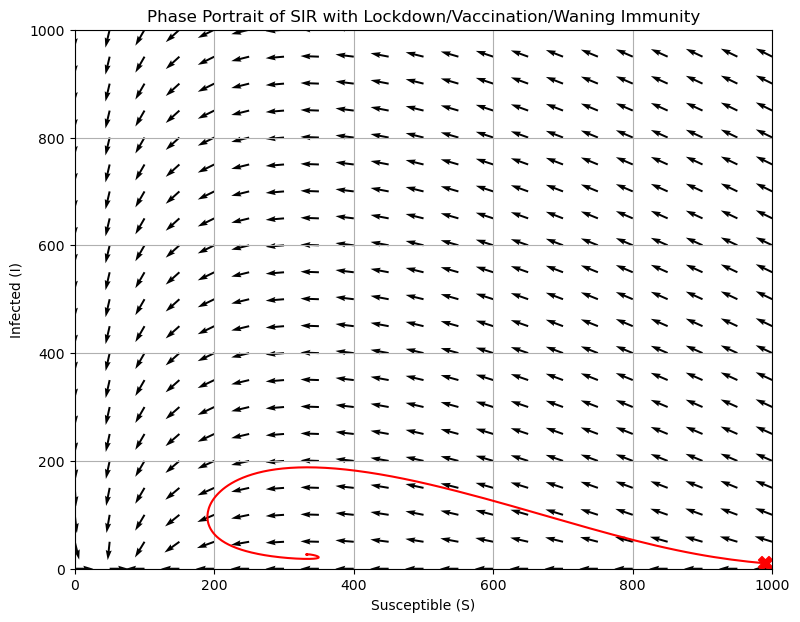

In [358]:
a = 3.0
b = 1.0
c = 0.1
e = 0.01
N = 1000

# Initialize solution arrays
steps = 10
S_vals = np.linspace(0, N, 2 * steps + 1)
I_vals = np.linspace(0, N, 2 * steps + 1)
SS, II = np.meshgrid(S_vals, I_vals)
RR = N - SS - II

u = -a * SS * II / N - c * SS + e * RR
v = a * SS * II / N - b * II

magnitude = np.sqrt(u**2 + v**2)
u_norm = u / (magnitude + 1e-8)
v_norm = v / (magnitude + 1e-8)

# Plot solution
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

# Plot arrows in phase plane
q = ax.quiver(SS, II, u_norm, v_norm, angles="xy")

# Plot trajectory and start point
ax.scatter(X0[0], X0[1], marker="X", color="r", s=100)
ax.plot(X[0, :], X[1, :], color="r", linewidth=1.5)


# Set title, axes labels and legends
ax.set_xlabel("Susceptible (S)")
ax.set_ylabel("Infected (I)")
ax.set_title("Phase Portrait of SIR with Lockdown/Vaccination/Waning Immunity")

ax.set_xlim(0, N)
ax.set_ylim(0, N)

plt.grid()
plt.show()

## SIR model with Mutation, Vaccination and Gradual Lockdown

In [359]:
from math import exp

In [360]:
def sir(t, X, pt, nc, b, c, e, N, lockdown=True):

    s = X[0]
    i = X[1]
    r = X[2]

    # Gradual lockdown
    if lockdown:
        nc = 1 + 5 * np.exp(-0.5 * max(t - 5, 0))

    a = pt * nc

    ds = -a * s * i / N - c * s + e * r
    di = a * i * s / N - b * i
    dr = b * i + c * s - e * r

    return [ds, di, dr]

In [361]:
# Set parameters according to the problem specs
tspan = [0.0, 10]
t_eval = np.arange(0, 10, 0.1)
nc = 8
pt = 0.5
b = 1
c = 0.1
e = 0.01
N = 1000

# S, I, R
X0 = [999, 1, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(
    lambda t, X: sir(t, X, pt, nc, b, c, e, N, lockdown=False),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T, X = sol.t, sol.y

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol_lock = solve_ivp(
    lambda t, X: sir(t, X, pt, nc, b, c, e, N, lockdown=True),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T_lock, X_lock = sol_lock.t, sol_lock.y

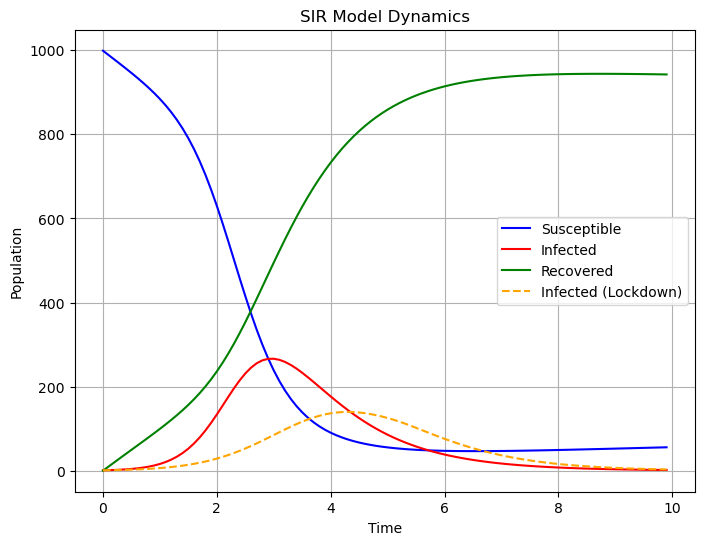

In [362]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.plot(T, X_lock[1], label="Infected (Lockdown)", color="orange", linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics")
ax.legend()
ax.grid()
plt.show()

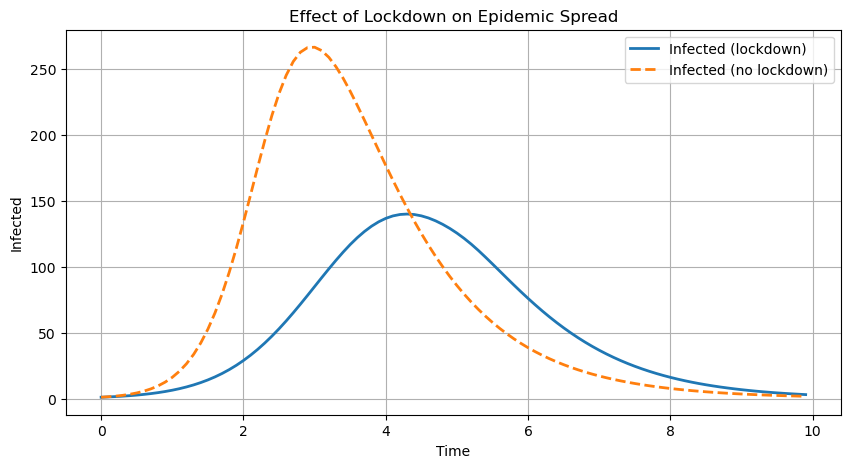

In [363]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(sol_lock.t, sol_lock.y[1], label="Infected (lockdown)", lw=2)
plt.plot(sol.t, sol.y[1], label="Infected (no lockdown)", lw=2, linestyle="--")
plt.xlabel("Time")
plt.ylabel("Infected")
plt.title("Effect of Lockdown on Epidemic Spread")
plt.legend()
plt.grid()
plt.show()

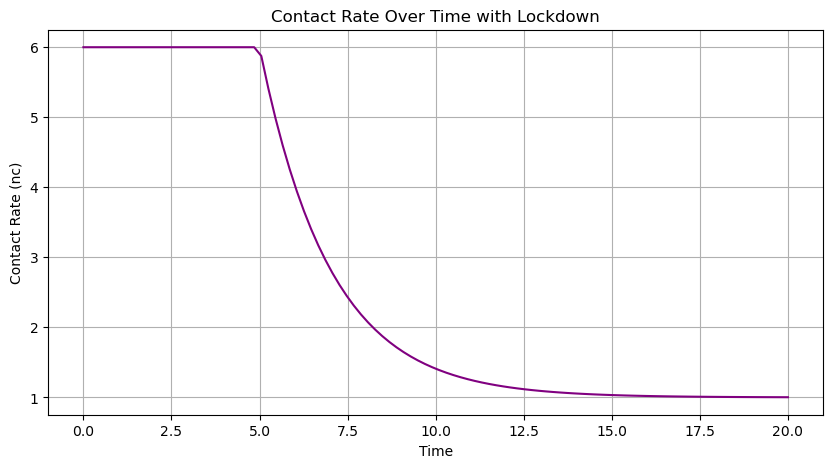

In [364]:
t = np.linspace(0, 20, 100)

ncs = [1 + 5 * np.exp(-0.5 * max(t_val - 5, 0)) for t_val in t]

plt.figure(figsize=(10, 5))
plt.plot(t, ncs, label="Contact Rate (nc)", color="purple")
plt.xlabel("Time")
plt.ylabel("Contact Rate (nc)")
plt.title("Contact Rate Over Time with Lockdown")
plt.grid()
plt.show()